In [1]:
import os
import pandas as pd
import numpy as np
import fitsio
import cudf
from numba import cuda
import cupy as cp
from pathlib import Path, PurePath
import matplotlib.pyplot as plt

In [78]:
def get_dist_mat(coords):
    coords_x = coords % 4096
    coords_y = coords // 4096
    coords_xb = coords_x[:, np.newaxis]
    coords_yb = coords_y[:, np.newaxis]
    dx_broadc = coords_x - coords_xb
    dy_broadc = coords_y - coords_yb
    dist_matrix = dx_broadc**2 + dy_broadc**2
    return dist_matrix

def get_dist_mat_gpu(coords):
    coords_x = coords % 4096
    coords_y = coords // 4096
    coords_xb = coords_x[:, cp.newaxis]
    coords_yb = coords_y[:, cp.newaxis]
#     dx_broadc = coords_x - coords_xb
#     dy_broadc = coords_y - coords_yb
#     dist_matrix = (coords_x - coords_xb)**2 + (coords_y - coords_yb)**2
    return (coords_x - coords_xb)**2 + (coords_y - coords_yb)**2

def get_rows_list(array, w1_idx, w2_idx):
    np_mask = (array[:, w1_idx] == 1) & (array[:, w2_idx] == 1)
    df_idx = np.nonzero(np_mask)[0]
    coords = array[np_mask, 0]
    dist_matrix = get_dist_mat(coords)
    select = dist_matrix < 2 
    select2 = np.triu(select, k=1)
    r,c = np.nonzero(select2)
    idx1, idx2 = df_idx[r], df_idx[c]
    return idx1, idx2

def get_rows_list_gpu(array, w1_idx, w2_idx):
    mask = (array[:, w1_idx] == 1) & (array[:, w2_idx] == 1)
    df_idx = cp.nonzero(mask)[0]
    coords = array[df_idx, 0]
    dist_matrix = get_dist_mat_gpu(coords)
    select = dist_matrix < 2 
    select2 = cp.triu(select, k=1)
    r,c = cp.nonzero(select2)
    idx1, idx2 = df_idx[r], df_idx[c]
    return idx1, idx2


def get_2coincidentals(array, w1_idx, w2_idx):
    idx1, idx2 = get_rows_list(array, w1_idx, w2_idx)
    records = [df0.loc[[i1, i2]][['coords', 'int1', 'int2', 'wref']] for i1, i2 in zip(idx1, idx2)]
    df_records = pd.concat(records, keys=list(range(len(records))))
    return df_records


def get_2clusters(array, w1_idx, w2_idx, group_n=None):
    idx1, idx2 = get_rows_list(array, w1_idx, w2_idx)
    # To remove conjugates
#     keep_mask = arr0[idx1, 3] != arr0[idx2, 3] 
#     recordsf = np.concatenate((arr0[idx1[keep_mask], 0:4], arr0[idx2[keep_mask], 0:4]), axis=1)
    
    records = np.concatenate((array[idx1, 0:4], array[idx2, 0:4]), axis=1)
    df_records = pd.DataFrame(records, columns=['coords1', 'int1_before', 'int1_after', 'wref1', 'coords2', 'int2_before', 'int2_after', 'wref2'])
    if group_n is not None:
        df_records['GroupNumber'] = group_n
    
    return df_records


def get_3clusters(array, w1_idx, w2_idx, w3_idx, group_n=None):
    df12 = get_2clusters(array, w1_idx, w2_idx, group_n=group_n)
    df13 = get_2clusters(array, w1_idx, w3_idx, group_n=group_n)
    series123 = df12['coords1'].loc[df12['coords1'].isin(df13['coords1'])]
    
    return series123


def get_2clusters_gpu(gpu_array, w1_idx, w2_idx):
    gidx1, gidx2 = get_rows_list_gpu(gpu_array, w1_idx, w2_idx)
    grecords = cp.concatenate([gpu_array[gidx1, 0:4], gpu_array[gidx2, 0:4]], axis=1)
    #grecords2 = cp.asfortranarray(grecords)
    #cudf_records = cudf.DataFrame.from_gpu_matrix(grecords2, columns=['coords1', 'int1_before', 'int1_after', 'wref1', 'coords2', 'int2_before', 'int2_after', 'wref2'])
    return records

In [39]:
data_dir = os.environ['SPIKESDATA']
spikes_db = pd.read_parquet(os.path.join(data_dir, 'spikes_df_2010.parquet'), columns=['GroupNumber', 'Time'], engine='pyarrow')
spikes_db.head()

,GroupNumber,Time
0,0,2010-05-13 00:00:02.090000+00:00
1,0,2010-05-13 00:00:03.570000+00:00
2,0,2010-05-13 00:00:05.070000+00:00
3,0,2010-05-13 00:00:06.580000+00:00
4,0,2010-05-13 00:00:08.080000+00:00


In [40]:
gdates = spikes_db.groupby('GroupNumber').nth(0)
print(len(gdates))
gdates.head()

1634668


,Time
GroupNumber,
0,2010-05-13 00:00:02.090000+00:00
1,2010-05-13 00:00:14.080000+00:00
2,2010-05-13 00:00:26.080000+00:00
3,2010-05-13 00:00:38.080000+00:00
4,2010-05-13 00:00:50.080000+00:00


### Load a parquet file (1 day of data)

In [41]:
parquet_dir = os.path.expanduser('~/raphael/data/AIA_Spikes/parquet_dataframes')
df0 = pd.read_parquet(PurePath(parquet_dir, '2010/05/df_coincidentals_2010_05_13.parquet'), engine='pyarrow')
df0.set_index('GroupNumber', inplace=True)
df0.loc[0].head()

,coords,int1,int2,wref,w0,w1,w2,w3,w4,w5,w6
GroupNumber,,,,,,,,,,,
0,23013,75,10,0,1,1,0,0,0,0,0
0,23287,157,9,0,1,0,0,1,0,0,0
0,27109,38,9,0,1,1,0,0,0,0,0
0,42997,285,9,0,1,0,0,1,0,0,0
0,47093,451,8,0,1,0,0,1,0,0,0


In [86]:
c = df0.groupby(level=0).size().rename('total count (>= 2-wave-overlaps)')
c.head()

GroupNumber
0    6852
1    6870
2    6498
3    6699
4    6503
Name: total count (>= 2-wave-overlaps), dtype: int64

In [87]:
seriesccount = df0[['w0', 'w1', 'w2', 'w3', 'w4', 'w5', 'w6']].sum(axis=1).rename('overlaps')
seriesccount.head()

GroupNumber
0    2
0    2
0    2
0    2
0    2
Name: overlaps, dtype: int64

In [88]:
df0['overlaps'] = seriesccount

In [89]:
c3 = df0.loc[df0['overlaps']==3].groupby(level=0).size().rename('3-wave-overlaps count')

In [90]:
dfcount = pd.concat([gdates.loc[c.index], c, c3], axis=1)
dfcount.set_index('Time', inplace=True)
dfcount.head()

,total count (>= 2-wave-overlaps),3-wave-overlaps count
Time,,
2010-05-13 00:00:02.090000+00:00,6852,147.0
2010-05-13 00:00:14.080000+00:00,6870,170.0
2010-05-13 00:00:26.080000+00:00,6498,99.0
2010-05-13 00:00:38.080000+00:00,6699,106.0
2010-05-13 00:00:50.080000+00:00,6503,105.0


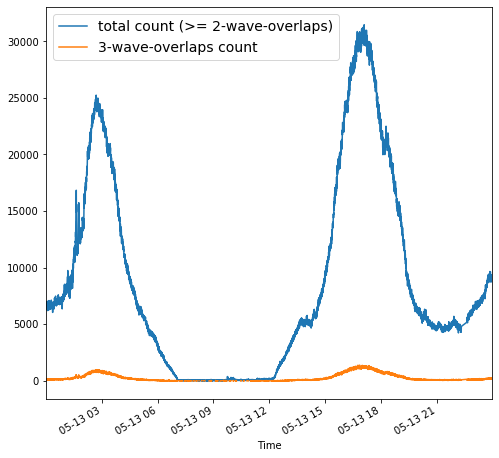

In [92]:
%matplotlib inline
dfcount.plot(figsize=(8,8))
plt.legend(fontsize=14)

In [50]:
print(len(df0.loc[seriesccount==5]))
df0.loc[seriesccount==3].head()

370


,coords,int1,int2,wref,w0,w1,w2,w3,w4,w5,w6
GroupNumber,,,,,,,,,,,
0,774854,654,7,0,1,0,0,0,1,1,0
0,1137483,111,27,0,1,0,0,1,1,0,0
0,1529089,127,53,0,1,0,1,0,0,1,0
0,1579121,281,68,0,1,1,0,0,1,0,0
0,1583217,243,68,0,1,1,0,0,1,0,0


### Design method to extract unique coincidental events, lifting any ambiguity (conjugates, redundancies, ...)

In [58]:
w1_idx = 4
w2_idx = 5
w3_idx = 6
w4_idx = 7

In [52]:
df_ = df0.loc[0]
print(len(df_))
df_.head()

6852


,coords,int1,int2,wref,w0,w1,w2,w3,w4,w5,w6
GroupNumber,,,,,,,,,,,
0,23013,75,10,0,1,1,0,0,0,0,0
0,23287,157,9,0,1,0,0,1,0,0,0
0,27109,38,9,0,1,1,0,0,0,0,0
0,42997,285,9,0,1,0,0,1,0,0,0
0,47093,451,8,0,1,0,0,1,0,0,0


In [54]:
groups = df0.index.unique()

In [55]:
events12 = [get_2clusters(df0.loc[group_n].values, w1_idx, w2_idx, group_n) for group_n in groups]
df_events12 = pd.concat(events12)
df_events12 = df_events12.loc[(df_events12.wref2 == 1)]
print(len(events12))
df_events12.head()

7114


,coords1,int1_before,int1_after,wref1,coords2,int2_before,int2_after,wref2,GroupNumber
1,27109,38,9,0,27108,11,0,1,0
3,272628,240,8,0,268532,111,0,1,0
4,272629,32,10,0,268533,20,0,1,0
6,349899,87,16,0,353995,285,0,1,0
8,353995,125,17,0,353995,285,0,1,0


In [60]:
events14 = [get_2clusters(df0.loc[group_n].values, w1_idx, w4_idx, group_n) for group_n in groups]
df_events14 = pd.concat(events14)
df_events14 = df_events14.loc[(df_events14.wref2 == 3)]
df_events14.head()

,coords1,int1_before,int1_after,wref1,coords2,int2_before,int2_after,wref2,GroupNumber
0,23287,157,9,0,27383,222,10,3,0
2,42997,285,9,0,42998,47,14,3,0
4,47093,451,8,0,47094,121,13,3,0
5,47094,25,9,0,47094,121,13,3,0
6,47094,25,9,0,42998,47,14,3,0


In [68]:
c12 = df_events12.groupby('GroupNumber').size().rename('coincidentals count for Wav 0 & Wav 1')
dfcount12 = pd.concat([gdates.loc[groups], c12], axis=1)
dfcount12.set_index('Time', inplace=True)

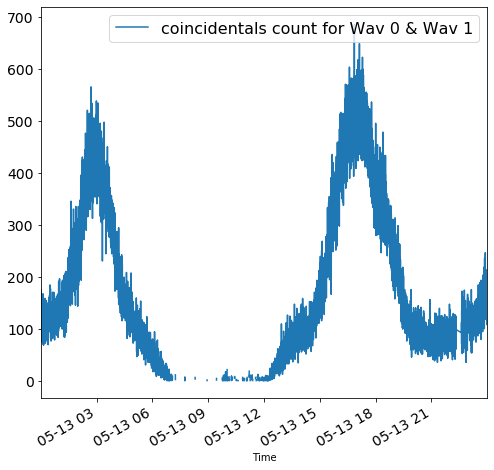

In [69]:
%matplotlib inline
ax = dfcount12.plot(figsize=(8,8), fontsize=14)
ax.legend(fontsize=16)

In [93]:
r_sun = 1578
crpix = 2048.5
nx = 4096
ny = 4096

In [104]:
gn = 0

coords1 = df_events12.loc[df_events12['GroupNumber']==gn]['coords1'].values
coords_x1 = coords % 4096
coords_y1 = coords // 4096

coords2 = df_events12.loc[df_events12['GroupNumber']==gn]['coords2'].values
coords_x2 = coords % 4096
coords_y2 = coords // 4096

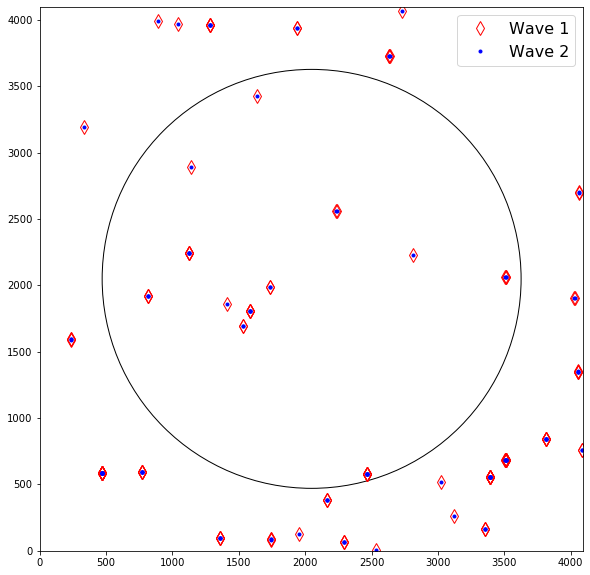

In [115]:
sdisk = plt.Circle((crpix, crpix), r_sun, color='black', fill=False)
fig, ax = plt.subplots(figsize=(10,10))
plt.xlim(0, nx-1)
plt.ylim(0, ny-1)
ax.set_aspect(1)
ax.add_artist(sdisk)
plt.plot(coords_x1, coords_y1, 'rd', ms=10, markerfacecolor='none', label='Wave 1')
plt.plot(coords_x2, coords_y2, 'b.', ms=6, label='Wave 2')
plt.legend(fontsize=16)